In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import label_binarize

# ----------------- Step 1: Load and Process Data -----------------

test_csv_path = r"C:\Black Book Project\HAM 10000\HAM10000_split\test_features_HC.csv"
valid_csv_path = r"C:\Black Book Project\HAM 10000\HAM10000_split\valid_features_HC.csv"

df_test = pd.read_csv(test_csv_path)
df_valid = pd.read_csv(valid_csv_path)

df_test.drop(columns=['Image_Name'], errors='ignore', inplace=True)
df_valid.drop(columns=['Image_Name'], errors='ignore', inplace=True)

X_test, y_test = df_test.drop(columns=['Label']).values, df_test['Label'].values
X_valid, y_valid = df_valid.drop(columns=['Label']).values, df_valid['Label'].values

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_valid = label_encoder.transform(y_valid)

num_classes = len(label_encoder.classes_)

# Balance dataset with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_test, y_test = smote.fit_resample(X_test, y_test)

# Normalize
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_valid = scaler.transform(X_valid)

X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)
X_valid, y_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.long)

batch_size = 64  # Increased batch size for better generalization
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)

# ----------------- Step 2: Define the Deep Residual MLP Model -----------------

class ResidualBlock(nn.Module):
    def __init__(self, input_size):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.bn1 = nn.BatchNorm1d(input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        self.bn2 = nn.BatchNorm1d(input_size)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)

        out += residual  # Skip connection
        out = self.activation(out)
        return out

class DeepMLP(nn.Module):
    def __init__(self, input_size, num_classes, num_blocks=8):
        super(DeepMLP, self).__init__()
        self.fc_initial = nn.Linear(input_size, 1024)
        self.bn_initial = nn.BatchNorm1d(1024)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.5)

        self.residual_blocks = nn.Sequential(*[ResidualBlock(1024) for _ in range(num_blocks)])

        self.fc_final = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.fc_initial(x)
        x = self.bn_initial(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.residual_blocks(x)

        x = self.fc_final(x)
        return x

# ----------------- Step 3: Training Setup -----------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_test.shape[1]
model = DeepMLP(input_size, num_classes).to(device)

# **Use Focal Loss for Imbalanced Classes**
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss()(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# ----------------- Step 4: Training Loop -----------------

num_epochs = 200
patience = 15
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    avg_train_loss = total_loss / len(test_loader)
    avg_val_loss = val_loss / len(valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training complete!")

# ----------------- Step 5: Model Evaluation -----------------

def evaluate_model(model, data_loader, label_encoder, dataset_name, device, num_classes):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(probs)

    print(f"\nClassification Report for {dataset_name}:\n", classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

evaluate_model(model, test_loader, label_encoder, "Test Set", device, num_classes)
evaluate_model(model, valid_loader, label_encoder, "Validation Set", device, num_classes)


Epoch 1/200 - Train Loss: 1.8725, Val Loss: 179.6148
Epoch 2/200 - Train Loss: 0.7536, Val Loss: 4.1178
Epoch 3/200 - Train Loss: 0.5316, Val Loss: 0.8064
Epoch 4/200 - Train Loss: 0.3223, Val Loss: 0.5297
Epoch 5/200 - Train Loss: 0.3682, Val Loss: 0.4819
Epoch 6/200 - Train Loss: 0.3407, Val Loss: 0.4277
Epoch 7/200 - Train Loss: 0.3846, Val Loss: 0.5888
Epoch 8/200 - Train Loss: 0.4376, Val Loss: 0.3417
Epoch 9/200 - Train Loss: 0.2656, Val Loss: 0.2401
Epoch 10/200 - Train Loss: 0.1962, Val Loss: 0.1928
Epoch 11/200 - Train Loss: 0.2107, Val Loss: 0.1832
Epoch 12/200 - Train Loss: 0.1827, Val Loss: 0.2192
Epoch 13/200 - Train Loss: 0.3276, Val Loss: 0.2489
Epoch 14/200 - Train Loss: 0.2176, Val Loss: 0.2106
Epoch 15/200 - Train Loss: 0.1618, Val Loss: 0.2231
Epoch 16/200 - Train Loss: 0.1965, Val Loss: 0.2243
Epoch 17/200 - Train Loss: 0.1421, Val Loss: 0.3078
Epoch 18/200 - Train Loss: 0.1399, Val Loss: 0.2672
Epoch 19/200 - Train Loss: 0.1346, Val Loss: 0.2019
Epoch 20/200 - Trai

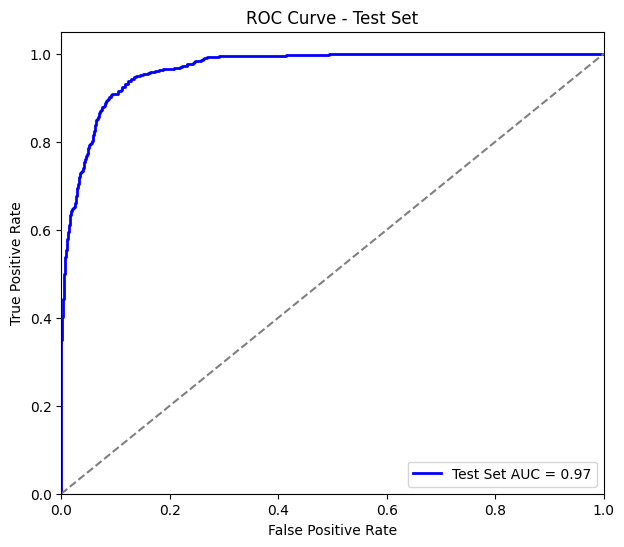

Test Set AUC Score: 0.9674


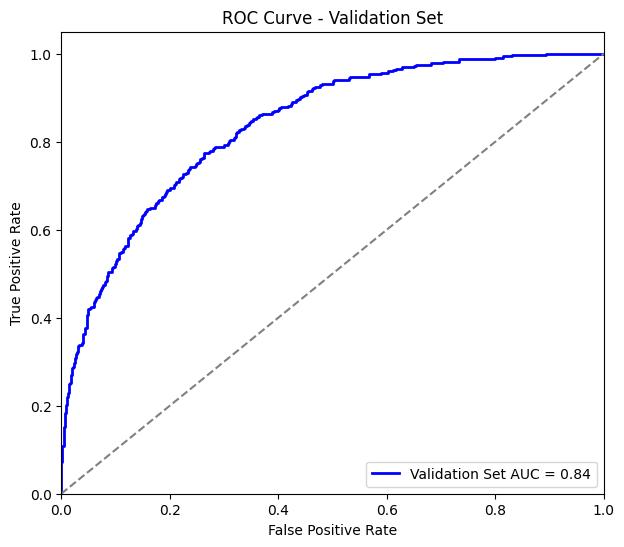

Validation Set AUC Score: 0.8387


In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_auc_curve(model, data_loader, device, num_classes, dataset_name):
    model.eval()
    all_labels, all_probs = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(y_batch.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Binarize labels for multi-class ROC
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute overall AUC (macro-average)
    fpr, tpr, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    overall_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{dataset_name} AUC = {overall_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

    print(f"{dataset_name} AUC Score: {overall_auc:.4f}")

# Call function separately for Test and Validation
plot_auc_curve(model, test_loader, device, num_classes, "Test Set")
plot_auc_curve(model, valid_loader, device, num_classes, "Validation Set")
